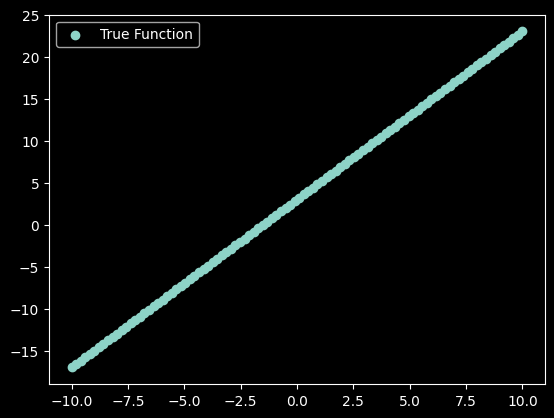

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import pandas as pd

# Define the function f(x) = 2x + 3
def true_function(x):
    return 2 * x + 3

# Generate synthetic data
x_data = np.linspace(-10, 10, 100).reshape(-1, 1)
y_data = true_function(x_data).reshape(-1, 1)

# Plot the true function
plt.scatter(x_data, y_data, label='True Function')
plt.legend()
plt.show()

In [2]:
key = jax.random.PRNGKey(42)

I0000 00:00:1697892389.199050   76883 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [3]:
from jaxmao.layers import Dense
dense = Dense(1, 1, activation=None, batch_norm=False, use_bias=True)
dense.init_params(key)
dense.set_training_mode()

In [4]:
# Initialize with custom weights: For simplicity, let's choose weight as 1 and bias as 0
custom_weights = np.array([[1.0]])  # Weight
custom_bias = np.array([0.0])  # Bias

dense.params['dense/simple_dense'].update({
    'weights' :  custom_weights,
    'biases' :  custom_bias,
})
dense.params['dense/simple_dense']

{'weights': array([[1.]]), 'biases': array([0.])}

In [5]:
dense.layers['dense/simple_dense'].params

{'weights': array([[1.]]), 'biases': array([0.])}

# sgd

In [6]:
sgd_df = pd.DataFrame({
    'loss' : [],
    'weight' : [],
    'bias' : [],
    'pred_sum' : []
})

from jaxmao.optimizers import GradientDescent
from jaxmao.losses import MeanSquaredError

from jaxmao.layers import Dense
dense = Dense(1, 1, activation=None, batch_norm=False, use_bias=True)
dense.init_params(key)
dense.set_training_mode()

dense.params['dense/simple_dense'].update({
    'weights' :  custom_weights,
    'biases' :  custom_bias,
})

mse = MeanSquaredError()
def loss_fn(model, params, x, y, state):
    y_pred, new_state = model.forward(params, x, state)
    loss = mse(y_pred, y)
    return (loss, new_state)

optimizer = GradientDescent(lr=0.01)
(loss, state), gradients = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)(dense, dense.params, x_data, y_data, dense.state)
print('g', gradients)
for _ in range(20):
    (loss, state), gradients = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)(dense, dense.params, x_data, y_data, dense.state)
    dense.params, optimizer.state = optimizer(dense.params, gradients, optimizer.state)

    weights = dense.params['dense/simple_dense']['weights']
    bias = dense.params['dense/simple_dense']['biases']
    y_pred = dense(dense.params, x_data)[0]
    y_pred_sum = y_pred.sum()
    loss = mse(y_pred, y_data)
    
    data_df = pd.DataFrame({'loss': loss, 'weight' : weights[0][0], 'bias': bias, 'pred_sum': y_pred_sum})
    sgd_df = pd.concat([sgd_df, data_df],
                    axis=0)

g {'dense/simple_dense': {'biases': Array([-8.050505], dtype=float32), 'weights': Array([[-49.15825]], dtype=float32)}}


/tmp/ipykernel_76883/3213919047.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sgd_df = pd.concat([sgd_df, data_df],


In [7]:
sgd_df.head(20)
sgd_df.to_csv('sgd_jaxmao.csv')

# adam

In [8]:
adam_df = pd.DataFrame({
    'loss' : [],
    'weight' : [],
    'bias' : [],
    'pred_sum' : []
})

from jaxmao.optimizers import Adam
from jaxmao.losses import MeanSquaredError

from jaxmao.layers import Dense
dense = Dense(1, 1, activation=None, batch_norm=False, use_bias=True)
dense.init_params(key)
dense.set_training_mode()

dense.params['dense/simple_dense'].update({
    'weights' :  custom_weights,
    'biases' :  custom_bias,
})

y_pred, _ = dense(dense.params, x_data)
print('sum', y_pred.sum())

mse = MeanSquaredError()
def loss_fn(model, params, x, y, state):
    y_pred, new_state = model.forward(params, x, state)
    loss = mse(y_pred, y)
    return (loss, new_state)

optimizer = Adam(dense.params)
(loss, state), gradients = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)(dense, dense.params, x_data, y_data, dense.state)
print('g', gradients)

for _ in range(20):
    (loss, state), gradients = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)(dense, dense.params, x_data, y_data, dense.state)
    dense.params, optimizer.state = optimizer.step(dense.params, gradients, optimizer.state)
    
    weights = dense.params['dense/simple_dense']['weights']
    bias = dense.params['dense/simple_dense']['biases']
    y_pred = dense(dense.params, x_data)[0]
    y_pred_sum = y_pred.sum()
    loss = mse(y_pred, y_data)
    
    data_df = pd.DataFrame({'loss': loss, 'weight' : weights[0][0], 'bias': bias, 'pred_sum': y_pred_sum})
    adam_df = pd.concat([adam_df, data_df],
                    axis=0)

sum 252.52524
g {'dense/simple_dense': {'biases': Array([-8.050505], dtype=float32), 'weights': Array([[-49.15825]], dtype=float32)}}


/tmp/ipykernel_76883/1329291687.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  adam_df = pd.concat([adam_df, data_df],


In [9]:
adam_df.to_csv('adam_jaxmao.csv')
adam_df.head(20)

,loss,weight,bias,pred_sum
0,78.29549,1.01,0.010000,255.5505
0,77.73029,1.0199978,0.019998,258.5751
0,77.16979,1.0299921,0.029993,261.59863
0,76.61409,1.0399812,0.039982,264.62064
0,76.06323,1.0499638,0.049966,267.6407
0,75.51732,1.0599384,0.059942,270.65833
0,74.976395,1.0699035,0.069909,273.6731
0,74.440544,1.0798576,0.079866,276.6846
0,73.909805,1.0897992,0.089811,279.69232
0,73.384254,1.0997269,0.099742,282.69592


# sgd cross entropy

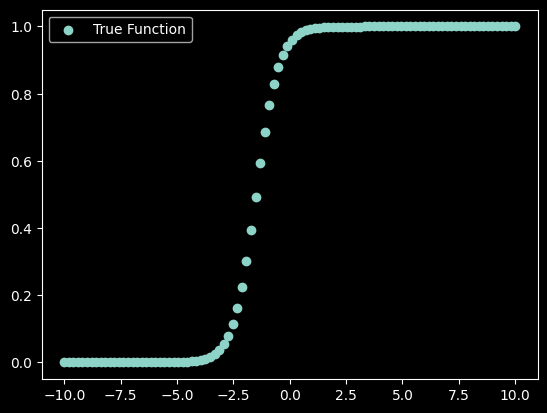

In [10]:
from jaxmao.layers import Sigmoid

def true_function(x):
    return Sigmoid()(2 * x + 3)

# Generate synthetic data
x_data = np.linspace(-10, 10, 100).reshape(-1, 1)
y_data = true_function(x_data).reshape(-1, 1)

# Plot the true function
plt.scatter(x_data, y_data, label='True Function')
plt.legend()
plt.show()

In [11]:
sgd_df = pd.DataFrame({
    'loss' : [],
    'weight' : [],
    'bias' : [],
    'pred_sum' : []
})

from jaxmao.optimizers import GradientDescent
from jaxmao.losses import BinaryCrossEntropy

from jaxmao.layers import Dense
dense = Dense(1, 1, activation='sigmoid', batch_norm=False, use_bias=True)
dense.init_params(key)
dense.set_training_mode()

dense.params['dense/simple_dense'].update({
    'weights' :  custom_weights,
    'biases' :  custom_bias,
})

cross_entropy_loss = BinaryCrossEntropy()
def loss_fn(model, params, x, y, state):
    y_pred, new_state = model.forward(params, x, state)
    loss = cross_entropy_loss(y_pred, y)
    return (loss, new_state)

optimizer = GradientDescent(lr=0.01)
(loss, state), gradients = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)(dense, dense.params, x_data, y_data, dense.state)
print('g', gradients)
for _ in range(20):
    (loss, state), gradients = jax.value_and_grad(loss_fn, argnums=1, has_aux=True)(dense, dense.params, x_data, y_data, dense.state)
    dense.params, optimizer.state = optimizer(dense.params, gradients, optimizer.state)

    weights = dense.params['dense/simple_dense']['weights']
    bias = dense.params['dense/simple_dense']['biases']
    y_pred = dense(dense.params, x_data)[0]
    y_pred_sum = y_pred.sum()
    loss = cross_entropy_loss(y_pred, y_data)
    
    data_df = pd.DataFrame({'loss': loss, 'weight' : weights[0][0], 'bias': bias, 'pred_sum': y_pred_sum})
    sgd_df = pd.concat([sgd_df, data_df],
                    axis=0)

g {'dense/simple_dense': {'biases': Array([-0.07425], dtype=float32), 'weights': Array([[-0.00533566]], dtype=float32)}}


/tmp/ipykernel_76883/3628197889.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sgd_df = pd.concat([sgd_df, data_df],


In [12]:
cross_entropy_loss.calculate_loss(y_pred, y_data)

Array(0.15636615, dtype=float32)

In [13]:
sgd_df.head(20)

,loss,weight,bias,pred_sum
0,0.15740831,1.0000534,0.000742,50.003674
0,0.15735298,1.0001067,0.001485,50.007347
0,0.15729769,1.0001599,0.002226,50.011017
0,0.15724245,1.0002129,0.002968,50.014687
0,0.15718727,1.000266,0.003709,50.018353
0,0.15713215,1.0003189,0.004449,50.02202
0,0.15707707,1.0003717,0.005190,50.02568
0,0.15702206,1.0004245,0.005930,50.029335
0,0.15696709,1.0004772,0.006669,50.032993
0,0.1569122,1.0005298,0.007408,50.03665
